In [1]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

In [216]:
def rhs_a2a_micro(t, psi, omega, k1, k2, triangles):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
    N = len(psi)

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for i, j, k in triangles:
        #print(i,j,k)
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    return triplet

In [205]:
def rhs_a2a_loop(t, psi, omega, k1, k2):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
    N = len(psi)
    nodes = range(N)

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for i in nodes:
        #print(i,j,k)
        # sin(2 oj - ok - oi)
        for j in nodes:
            for k in nodes:
                oi = psi[i]
                oj = psi[j]
                ok = psi[k]
                triplet[i] += sin(oj + ok - 2 * oi)
                #triplet[j] += sin(oi + ok - 2 * oj)
                #triplet[k] += sin(oj + oi - 2 * ok)

    return triplet

In [206]:
triangles

[{0, 1, 2}]

In [236]:
def rhs_triplet_all_asym(t, psi, omega, k1, k2):
    """Right-hand side of the ODE.
    All-to-all, only triplets.
    Coupling function: sin(oj + ok - 2oi)

    Parameters
    ----------
    t: float
        Time
    psi: array of float
        Phases to integrate
        
        -2 cos(x) cos(y) cos(z) sin(x) 
    + cos^2(x) cos(z) sin(y) 
    - cos(z) sin^2(x) sin(y) 
    + cos^2(x) cos(y) sin(z) 
    - cos(y) sin^2(x) sin(z) 
    + 2 cos(x) sin(x) sin(y) sin(z)
    
    -2 cos(oi) cos(oj) cos(ok) sin(oi)
    + cos^2(oi) cos(ok) sin(oj)
    - cos(ok) sin^2(oi) sin(oj)
    + cos^2(oi) cos(oj) sin(ok)
    - cos(oj) sin^2(oi) sin(ok)
    + 2 cos(oi) sin(oi) sin(oj) sin(ok)
    """

    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    sum_cos_psi = np.sum(cos_psi)
    sum_sin_psi = np.sum(sin_psi)

    # oj + ok - 2oi
    triplet = (
        -2 * sum_cos_psi**2 * sin_psi * cos_psi
        + cos_psi**2 * sum_cos_psi * sum_sin_psi
        - sum_cos_psi * sin_psi**2 * sum_sin_psi
        + sum_cos_psi * cos_psi**2 * sum_sin_psi
        - sum_cos_psi * sin_psi**2 * sum_sin_psi
        + 2 * cos_psi * sin_psi * sum_sin_psi**2
    )
    
    return triplet


In [220]:
N = 100 

H = xgi.complete_hypergraph(N, max_order=2)

triangles = H.edges.filterby("size", 3).members()

In [221]:
omega = 0
k1 = 0
k2 = 1
t = 0

In [222]:
psi = generate_state(N=N, kind="random", noise=0) # random state

In [223]:
xx = rhs_a2a_micro(t, psi, omega, k1, k2, triangles)
xx

array([ 74.1020768 ,  33.41058615,  -9.29429351,  94.55031987,
       -32.70013572, -44.44096829, -64.32485893,  12.88546412,
        -7.77423026, -64.89379988,  21.14173613, -25.78478924,
       -40.65224169,   0.56808554,  16.07217229,  37.60912479,
        43.64655108, -18.51587471, -83.63288901,  91.24965864,
         0.20359585,  25.76083727,  -9.29163908,  68.72844932,
       -51.30634445, -18.38986476,  64.9397235 ,  10.59394542,
        47.57819069,  47.82135479, -67.77416395,  69.58687605,
       -85.29549008,  68.19268024,  64.92698386,  46.07180757,
        85.84069289,  67.98170004,  53.69537886, -86.2363764 ,
       -32.0638804 , -38.47220734, -25.4998998 , -83.93124668,
       -63.08048106, -20.57461788,  26.7113761 , -44.87583403,
       -28.52163678, -53.59191023, -47.12831656, -56.84898316,
        60.44711202, -27.63551284, -57.63540733, -46.83810952,
        87.59444185,  27.56051277,  25.35671781,   2.36338357,
        60.07158769, -16.83324464,  67.49299468,  34.42

In [224]:
yy = rhs_triplet_all_asym(t, psi, omega, k1, k2)
yy

array([ 58.88882313,  27.94994167,  11.1037233 ,  80.8385714 ,
       -12.24158212, -52.23939279, -44.82307495,  11.7972929 ,
       -23.3447822 , -45.42441418,  21.12579683, -31.42139129,
       -38.28239261,  -2.0300345 ,   0.3364805 ,  39.96056777,
        27.95346402, -23.32679272, -65.81274782,  79.33328209,
        -2.43794956,  21.04883359, -24.84506186,  81.86055456,
       -31.23346521, -23.18644275,  73.08722307,   9.21775369,
        65.07058514,  32.15988874, -80.94390596,  80.21799433,
       -75.87676665,  81.62034499,  49.49401784,  30.39613552,
        74.79322164,  81.51243753,  46.23875523, -68.79839617,
       -11.59941523, -36.36764366,  -4.99982907, -74.83049347,
       -76.88317358, -35.97133532,  10.96113497, -52.72676369,
       -27.58556906, -62.54215351, -26.9301797 , -66.24541243,
        76.10703882, -26.80050603, -71.85519256, -61.57695171,
        76.2911332 ,  11.81069901,  20.68435618, -13.30039607,
        51.97104517, -17.19751492,  81.24182037,  18.69

In [225]:
zz = rhs_a2a_loop(t, psi, omega, k1, k2)
zz

array([ 58.88882313,  27.94994167,  11.1037233 ,  80.8385714 ,
       -12.24158212, -52.23939279, -44.82307495,  11.7972929 ,
       -23.3447822 , -45.42441418,  21.12579683, -31.42139129,
       -38.28239261,  -2.0300345 ,   0.3364805 ,  39.96056777,
        27.95346402, -23.32679272, -65.81274782,  79.33328209,
        -2.43794956,  21.04883359, -24.84506186,  81.86055456,
       -31.23346521, -23.18644275,  73.08722307,   9.21775369,
        65.07058514,  32.15988874, -80.94390596,  80.21799433,
       -75.87676665,  81.62034499,  49.49401784,  30.39613552,
        74.79322164,  81.51243753,  46.23875523, -68.79839617,
       -11.59941523, -36.36764366,  -4.99982907, -74.83049347,
       -76.88317358, -35.97133532,  10.96113497, -52.72676369,
       -27.58556906, -62.54215351, -26.9301797 , -66.24541243,
        76.10703882, -26.80050603, -71.85519256, -61.57695171,
        76.2911332 ,  11.81069901,  20.68435618, -13.30039607,
        51.97104517, -17.19751492,  81.24182037,  18.69

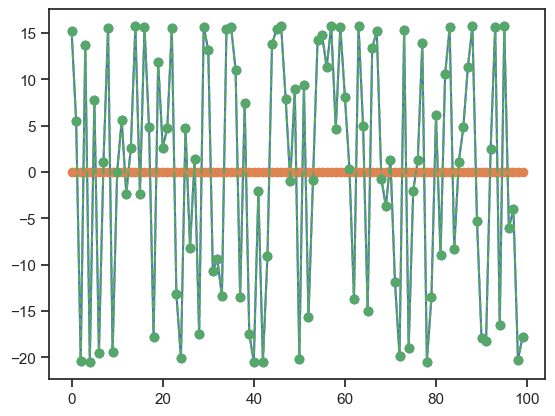

In [235]:
plt.plot(xx - yy, "o-")
plt.plot(yy -zz, "o-")
plt.plot(xx-zz, "o--")

In [227]:
%timeit rhs_a2a_micro(t, psi, omega, k1, k2, triangles)

152 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [228]:
%timeit rhs_a2a_loop(t, psi, omega, k1, k2)

366 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [229]:
%timeit rhs_triplet_all_asym(t, psi, omega, k1, k2)

13.8 µs ± 39.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
